In [1]:
import argparse
import torch
import pickle 
import numpy as np 
import os 
import math 
import random 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.io

import data 

from sklearn.decomposition import PCA
from torch import nn, optim
from torch.nn import functional as F

from detm import DETM
from utils import nearest_neighbors, get_topic_coherence

import pandas as pd

device: cuda:3
device: cuda:3


In [2]:
from sklearn import cluster
from sklearn import metrics

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
root_dir = '/home/yiyi/nlp_tm/'

In [5]:
num_topics = 10
filepath = os.path.join(root_dir, f'datasets/df_detm_topics_k{num_topics}_confidence.csv')

In [7]:
df = pd.read_csv(filepath, index_col=0)

In [23]:
d =df['text'].groupby(df['topic']).count()

In [44]:
d

topic
0        33
1     24229
2       830
3     35488
4     62821
5         3
6      3771
7    183396
8      3912
9     45614
Name: text, dtype: int64

In [45]:
df[df['topic']==5]

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,cossim
id,,,,,,,,,,,,,,,
1128019774963953665,"[19473, 7513, 1100, 18624, 4144, 6866, 8163, 1...",6,ES,1128019774963953665,Stand up and rise your hands to welcome queen ...,2019-05-13T19:30:46.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",104525958,"{'hashtags': [{'start': 58, 'end': 64, 'tag': ...",2019,5,13,stand rise hand welcome queen delicia model ri...,5,-0.037695
1128353566152904710,"[17229, 14850, 15788, 8369, 8332, 11159, 11965...",6,GB,1128353566152904710,A tale of two capital cities. 🏴󠁧󠁢󠁷󠁬󠁳󠁿 Single @...,2019-05-14T17:37:08.000Z,"{'place_id': '68f3012fe4848e35', 'coordinates'...",592598840,"{'hashtags': [{'start': 73, 'end': 82, 'tag': ...",2019,5,14,tale capital city single ticket merthyr caerdy...,5,-0.034408
1138606710791258112,"[1042, 19649, 14651, 10729, 11488, 17136, 1042...",6,FR,1138606710791258112,Dear Cell - Perception of Self and Nonself in ...,2019-06-12T00:39:28.000Z,"{'place_id': '4c6100a96901fb5e', 'place': {'fu...",220414639,"{'hashtags': [{'start': 266, 'end': 280, 'tag'...",2019,6,12,dear cell perception self nonself life fellow ...,5,-0.017864


In [13]:
df_sampled = df[df['cossim']>0]

In [40]:
ds = df_sampled['text'].groupby(df_sampled['topic']).count()

In [43]:
ds

topic
0       23
1    13249
2      385
3    19521
4    26400
6     1804
7    96374
8     2510
9    24350
Name: text, dtype: int64

In [34]:
d_stats = pd.DataFrame()

In [37]:
d_stats['All'] = d.values

In [38]:
d_stats.index=d.index

In [41]:
d_stats['Filtered']= ds.values

ValueError: Length of values does not match length of index

In [33]:
d.values

array([    33,  24229,    830,  35488,  62821,      3,   3771, 183396,
         3912,  45614])

In [ ]:
d

In [14]:
len(df_sampled)

184616

In [21]:
df_sampled.sort_values(by='cossim', ascending=False).tail(20)

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,cossim
id,,,,,,,,,,,,,,,
677904232255791104,"[8230, 4693, 2110, 7314, 11263, 10732, 10665]",2,PL,677904232255791104,#vscocam brr that looks cold. Don't know what ...,2015-12-18T17:32:18.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",1316189059,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'v...",2015,12,18,vscocam brr look cold know happen cloud trek l...,9,0.000010
832898073894461440,"[6566, 1402, 6081, 9409, 15344]",4,GB,832898073894461440,My name is Maddy and ● I AM AN IMMIGRANT●#IAmA...,2017-02-18T10:22:29.000Z,"{'place_id': '457b4814b4240d87', 'coordinates'...",55571612,"{'urls': [{'start': 83, 'end': 106, 'url': 'ht...",2017,2,18,maddy immigrant iamanimmigrant london united k...,3,0.000009
372465943349575680,"[15981, 20243, 1377, 10279, 2160, 13628, 14943...",0,IT,372465943349575680,"#Syria sinks #stocks, boosts #oil. #SEC expect...",2013-08-27T21:09:35.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",396667365,"{'urls': [{'start': 102, 'end': 124, 'url': 'h...",2013,8,27,syria sink stock boost oil sec expect nasdaq g...,3,0.000009
555852976842354688,"[13516, 16240, 12846, 8332, 17622, 8907]",2,GB,555852976842354688,@eastcoastbantam ok good luck I've given my ti...,2015-01-15T22:24:11.000Z,"{'place_id': '18787248c831e8e4', 'coordinates'...",493978564,"{'mentions': [{'start': 0, 'end': 16, 'usernam...",2015,1,15,ok good luck give ticket son bantam exile sarf,9,0.000008
1142015297311989761,"[9315, 1439, 4608, 7705, 1354, 2562]",6,GB,1142015297311989761,#Poets from our #ExiledWritersInk #OpenMic las...,2019-06-21T10:23:59.000Z,"{'place_id': '03a5820911d90b76', 'place': {'fu...",856688659,"{'hashtags': [{'start': 0, 'end': 6, 'tag': 'P...",2019,6,21,poet exiledwritersink openmic night introduce ...,7,0.000008
1172088426461577216,"[5685, 15865, 14408, 20812, 332, 9501, 20192, ...",6,GB,1172088426461577216,@mawgooner @Paulfarrant01 Source Tim Morgan bl...,2019-09-12T10:03:51.000Z,"{'place_id': '0905cd8b7f71a889', 'place': {'fu...",817042482932449280,"{'annotations': [{'start': 33, 'end': 42, 'pro...",2019,9,12,source tim morgan blog immigration euroland de...,7,0.000008
1184026243571834881,"[6566, 20089, 4860, 7289, 20194, 1139, 20267, ...",6,GB,1184026243571834881,Exactly!!!Refugee immigrant (Indian origin - b...,2019-10-15T08:40:29.000Z,"{'place_id': '03a5820911d90b76', 'place': {'fu...",295860858,"{'urls': [{'start': 205, 'end': 228, 'url': 'h...",2019,10,15,exactlyrefugee immigrant indian origin kick ug...,7,0.000007
1191664370293583872,"[15981, 9434, 16378, 4495, 14162]",6,IT,1191664370293583872,#Syria......................#Christmas2019 ano...,2019-11-05T10:31:40.000Z,"{'place_id': 'c215eaebf18fb694', 'place': {'id...",138530001,"{'hashtags': [{'start': 0, 'end': 6, 'tag': 'S...",2019,11,5,syria christmas nice appropriate gift beloved,7,0.000007
1223143353233084416,"[9399, 5205, 7902, 17485, 4986, 9741, 3489, 11...",7,GB,1223143353233084416,I wrote this in 2016 after the referendum. Bre...,2020-01-31T07:17:54.000Z,"{'place_id': '0c4f58af36a910a6', 'place': {'fu...",96037033,"{'annotations': [{'start': 43, 'end': 52, 'pro...",2020,1,31,write referendum brexit day finally arrive ill...,7,0.000006


In [15]:
df_sampled.sample(10)

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,cossim
id,,,,,,,,,,,,,,,
506195655237586944,"[9987, 2353, 20773, 13115, 691, 15757, 18279, ...",1,GB,506195655237586944,Asylum the doors are so wide open we even go t...,2014-08-31T21:43:43.000Z,"{'place_id': '569c1d39d5de5775', 'coordinates'...",299858424,"{'hashtags': [{'start': 99, 'end': 113, 'tag':...",2014,8,31,asylum door wide open spain bring nhs dependen...,4,0.021279
545685219366686721,"[13011, 6566, 4424, 4795, 20621, 13819, 2110]",1,GB,545685219366686721,@NorseFired @Ratillathehun @WomenDefyUKIP @Jan...,2014-12-18T21:01:09.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",580962306,"{'mentions': [{'start': 0, 'end': 11, 'usernam...",2014,12,18,care immigrant home leave eu wo happen,4,0.022647
1272119374015496193,"[5048, 9433, 10155, 12530, 8247, 1229, 16517, ...",7,FR,1272119374015496193,We have a few different species of woodpecker ...,2020-06-14T10:51:08.000Z,"{'place_id': '3db6839eee4fd97d', 'place': {'fu...",1085484816,"{'hashtags': [{'start': 154, 'end': 164, 'tag'...",2020,6,14,different specie woodpecker hear time hard spo...,7,0.003891
467970871555268609,"[12121, 13618, 14534, 8907, 4361, 7412]",1,NL,467970871555268609,As a world we are living in a community of exi...,2014-05-18T10:12:04.000Z,"{'place_id': '182e62b1b1ccd2b3', 'coordinates'...",19081729,"{'mentions': [{'start': 93, 'end': 103, 'usern...",2014,5,18,world live community exile refugee border,4,0.032524
1193193153085542406,"[2315, 12817, 14272, 14838, 5274, 19351, 9647,...",6,GB,1193193153085542406,@jeremycorbyn 🔔🔚 is a #Hypocrite . Thhe younge...,2019-11-09T15:46:30.000Z,"{'place_id': '2289ea7a116814d5', 'place': {'fu...",979493810,"{'hashtags': [{'start': 22, 'end': 32, 'tag': ...",2019,11,9,hypocrite thhe young gullible generation brain...,7,0.039245
1262512708106084354,"[17198, 5052, 12606, 332]",7,GB,1262512708106084354,@RA_Sikdar You guys have to decide where is th...,2020-05-18T22:37:40.000Z,"{'place_id': '5233a0505ea12908', 'place': {'fu...",341045856,"{'mentions': [{'start': 0, 'end': 10, 'usernam...",2020,5,18,guy decide left immigration,7,0.058217
812707260665303040,"[11403, 15964, 16574, 10685, 1431, 12121, 1650...",3,FR,812707260665303040,Happy Hanoukat my Friends 😉😘✡️🕎🇮🇱🎉 #marseille ...,2016-12-24T17:11:24.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",291975330,"{'hashtags': [{'start': 35, 'end': 45, 'tag': ...",2016,12,24,happy hanoukat friend marseille france europe ...,4,0.062648
1132613082407219202,"[12228, 19801, 15788, 20857, 6081, 2472, 1884,...",6,GB,1132613082407219202,Traveling between these two EUROPEAN cities to...,2019-05-26T11:42:56.000Z,"{'place_id': '8ef32ff56ef11c22', 'place': {'fu...",1628933420,"{'urls': [{'start': 280, 'end': 303, 'url': 'h...",2019,5,26,travel european city today london berlin freed...,1,0.018001
1140734392844902400,"[7480, 16564, 9153, 9692, 8386, 11310, 17624, ...",6,FR,1140734392844902400,Backstage: I SAVED THE FISH POP+UP #IllegalAli...,2019-06-17T21:34:07.000Z,"{'place_id': '09f6a7707f18e0b1', 'place': {'fu...",8433812,"{'urls': [{'start': 279, 'end': 302, 'url': 'h...",2019,6,17,backstage save fish popup illegalalien nitestr...,1,0.036752


In [12]:
df.head()

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,cossim
id,,,,,,,,,,,,,,,
285908615561363456,"[13807, 12242, 16517, 4854, 16885, 13840, 7284...",0,GB,285908615561363456,"Completely missed the New Year beginning, too ...",2013-01-01T00:41:40.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",174028844,"{'hashtags': [{'start': 59, 'end': 80, 'tag': ...",2013,1,1,completely miss new year beginning engross car...,3,-0.011897
285909630868152320,"[11403, 16517, 13618, 1431, 1404, 1881]",0,DE,285909630868152320,happy new year all of you who lives in #europe...,2013-01-01T00:45:42.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",615040794,"{'hashtags': [{'start': 39, 'end': 46, 'tag': ...",2013,1,1,happy new year live europe party start right,7,-0.008603
285915248383361026,"[638, 2601, 20286]",0,GB,285915248383361026,Damien Sandow is awesome #YoureWelcome,2013-01-01T01:08:01.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",73127632,"{'annotations': [{'start': 0, 'end': 12, 'prob...",2013,1,1,damien sandow awesome yourewelcome,7,-0.013885
285921849446117376,"[17018, 9987]",0,GB,285921849446117376,Ryan was looking at me like I needed to be in ...,2013-01-01T01:34:15.000Z,"{'place_id': 'a3f4491c1a3bfe66', 'coordinates'...",398595226,"{'annotations': [{'start': 0, 'end': 3, 'proba...",2013,1,1,ryan look like need asylum troublemaker come,7,-0.008414
285922536942866432,"[2721, 16517, 12121]",0,GB,285922536942866432,#welcome #to #2013 #i #hope #this #year #is #b...,2013-01-01T01:36:59.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",191530036,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'w...",2013,1,1,welcome hope year well litte world know,7,-0.010270


In [10]:
len(df_sampled)

360064

In [19]:
df_75 = pd.read_csv(filepath, index_col=0)

In [21]:
df_25= pd.read_csv(filepath, index_col=0)

In [16]:
df_50 = pd.read_csv(filepath, index_col=0)

In [17]:
df_50.head()

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,cossim
id,,,,,,,,,,,,,,,
285908615561363456,"[13807, 12242, 16517, 4854, 16885, 13840, 7284...",0,GB,285908615561363456,"Completely missed the New Year beginning, too ...",2013-01-01T00:41:40.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",174028844,"{'hashtags': [{'start': 59, 'end': 80, 'tag': ...",2013,1,1,completely miss new year beginning engross car...,6,0.039144
285909630868152320,"[11403, 16517, 13618, 1431, 1404, 1881]",0,DE,285909630868152320,happy new year all of you who lives in #europe...,2013-01-01T00:45:42.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",615040794,"{'hashtags': [{'start': 39, 'end': 46, 'tag': ...",2013,1,1,happy new year live europe party start right,6,0.038019
285915248383361026,"[638, 2601, 20286]",0,GB,285915248383361026,Damien Sandow is awesome #YoureWelcome,2013-01-01T01:08:01.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",73127632,"{'annotations': [{'start': 0, 'end': 12, 'prob...",2013,1,1,damien sandow awesome yourewelcome,6,0.047056
285921849446117376,"[17018, 9987]",0,GB,285921849446117376,Ryan was looking at me like I needed to be in ...,2013-01-01T01:34:15.000Z,"{'place_id': 'a3f4491c1a3bfe66', 'coordinates'...",398595226,"{'annotations': [{'start': 0, 'end': 3, 'proba...",2013,1,1,ryan look like need asylum troublemaker come,6,0.068725
285922536942866432,"[2721, 16517, 12121]",0,GB,285922536942866432,#welcome #to #2013 #i #hope #this #year #is #b...,2013-01-01T01:36:59.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",191530036,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'w...",2013,1,1,welcome hope year well litte world know,6,0.038114


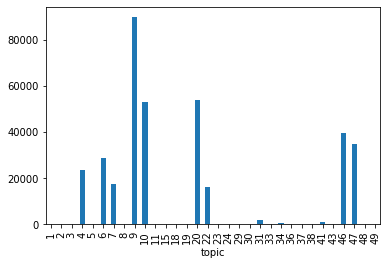

In [11]:
df['text'].groupby(df['topic']).count().plot(kind='bar')

In [23]:
df_25['topic'].value_counts()

16    85755
22    77262
20    53648
17    46619
15    40900
11    28843
3     17307
9      7654
14     1989
24      108
13        7
8         3
4         1
1         1
Name: topic, dtype: int64

In [24]:
df_75['topic'].value_counts()

69    90796
55    86117
37    52921
51    40866
17    28788
48    23441
7     17286
22    13545
72     1853
0      1607
3       876
56      386
46      299
21      196
19      168
54      158
64      115
67       96
58       93
61       70
62       58
63       54
59       54
36       48
35       42
53       32
32       29
14       26
15       23
74       22
13       10
8         9
71        6
60        3
47        2
42        1
9         1
Name: topic, dtype: int64

In [14]:
len(df['topic'].value_counts())

32

In [15]:
df['topic'].value_counts()

9     89811
20    53644
10    53082
46    39324
47    34722
6     28837
4     23444
7     17366
22    16272
31     1558
41      888
34      457
8       189
15      144
19      113
30       49
38       46
37       43
2        31
36       27
3        10
5        10
33        8
43        5
49        4
23        3
1         3
11        2
18        2
48        1
24        1
29        1
Name: topic, dtype: int64